# # Predict Customer Churn - Train Baseline Models 

This project is to build a predictive machine learning model using the customer churn data available at Kaggle website. <br>
Part 3 will look at training various classification models and hyperparameter tuning selected candidate models.<br>

The classification algorithms to be considered:
1. KNN
2. logistic regression
3. Decision Trees 
4. SVM linear
5. SVM RBF
6. neural network (multi-layer perceptron)
7. Guassian process
8. Naive-Bayes (GaussianNB)
9. Quadratic Discriminant Analysis
10. Ensemble model 
    - Random Forest
    - Extra Trees
    - ADAboosting
    - Gradient Boosting
    - XGBoost

## Prepare data
### Global functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from time import time

from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
# from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer

import customfunctions

In [2]:
# Calculate roc_auc score
def calculate_roc_auc_score(model,X, y): 
    pred_proba = model.predict_proba(X)
    roc_auc = roc_auc_score(y, pred_proba[:,1])
    return roc_auc

### Read in data

In [3]:
## Read in data
df0 = pd.read_csv('./data/visathon_train_data.csv')#,index=customer_id)
print('Shape: {}'.format(df0.shape))
df0.sample(5)

Shape: (17654, 20)


,customer_id,vintage,age,gender,dependents,occupation,customer_nw_category,branch_code,days_since_last_transaction,current_balance,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn
17005,23308.0,3051.0,54.0,Male,2.0,Accountant,High,523.0,0.0,12964.25,45146.42,18900.63,13894.29,16166.57,8792.51,43860.62,3614.73,NaN,26693.97,Yes
15423,21122.0,4266.0,61.0,Female,0.0,Accountant,High,7.0,48.0,1374.77,1712.26,1703.63,2119.62,0.33,542.89,156.73,647.03,1383.64,1759.63,No
14012,19196.0,1519.0,35.0,Male,0.0,Accountant,Medium,20.0,41.0,22675.78,22479.53,23048.75,25045.84,0.06,15.63,512.91,417.31,22608.42,22953.98,Yes
12723,17433.0,661.0,30.0,Female,0.0,Accountant,Medium,1673.0,273.0,14871.88,14879.24,14954.82,15121.88,0.64,0.64,8.00,NaN,14878.22,14898.43,Yes
1160,1585.0,3140.0,47.0,Male,0.0,Engineer,Medium,647.0,52.0,17463.56,17460.90,10934.92,158.03,0.51,17157.66,0.51,NaN,17462.73,14910.35,Yes


### Split data

In [4]:
target = 'churn'
X = df0.drop(target,axis=1).copy()
y = df0[target].copy()

In [99]:
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.25, random_state=10086)
print('X_train shape: {}\nX_valid shape: {}\ny_train shape: {}\ny_valid shape: {}'.format( X_train.shape, X_valid.shape, y_train.shape, y_valid.shape))

X_train shape: (13240, 19)
X_valid shape: (4414, 19)
y_train shape: (13240,)
y_valid shape: (4414,)


## Load data pipelines

In [100]:
pipeline_data = joblib.load('pipeline_data0.joblib')

In [101]:
X_train_transformed = pipeline_data.transform(X_train)
X_valid_transformed = pipeline_data.transform(X_valid)
y_train_transformed = y_train.map({"Yes":1,"No":0})
y_valid_transformed = y_valid.map({"Yes":1,"No":0})
X_train_transformed.shape, X_valid_transformed.shape

((13240, 30), (4414, 30))

Once the data sets are transformed, the next step is to use the transformed data to train models.

## Train classification models
This section we will look at screen various classification algorithms to select a few promising candidates for further tuning.

### Model set 1
This model set includes 9 scikit-learn classification algorithms (excluding those from ensemble family). The classification algorithms from the ensumble family will be discussed in ***Model set 2*** section.

#### 1. Select candidate models

In [5]:
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

In [8]:
# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
# Model seclection
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, randint, uniform

# Model evaluation
from sklearn.metrics import roc_auc_score, roc_curve

from time import time

In [26]:
names = [
    "K Nearest Neighbors",
    "Logistic Regression",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Neural Net",
    "Naive Bayes",
    "Quadratic Discriminant Analysis",
    "Gaussian Process",
    "Random Forest",
    "Extra Trees",
    "ADAboosting",
    "Gradient Boosting",
    "XGBoost",
]

classifiers = [
    KNeighborsClassifier(3),
    LogisticRegression(max_iter=500, n_jobs=-1, random_state=15611),
    SVC(kernel="linear", C=0.025, probability=True, random_state=15611),
    SVC(gamma=2, C=1, probability=True, random_state=15611),
    DecisionTreeClassifier(max_depth=5, random_state=15611),
    MLPClassifier(alpha=1, max_iter=1000, random_state=15611),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=15611),
    RandomForestClassifier(max_depth=2, random_state=15611,n_jobs=-1),
    ExtraTreesClassifier(random_state=15611,n_jobs=-1),
    AdaBoostClassifier(random_state=15611),
    GradientBoostingClassifier(random_state=15611),
    XGBClassifier(random_state=15611)
]

In [28]:
# iterate over classifiers

score = {}
model = {}
for name, clf in zip(names, classifiers):
    start = time()   
    print("Fitting: {}".format(name))
    clf.fit(X_train_transformed, y_train_transformed)
    pred_proba = clf.predict_proba(X_valid_transformed)
    roc_auc = roc_auc_score(y_valid_transformed, pred_proba[:,1])
    score[name] = roc_auc
    model[name] = clf
    print("{} has a roc_auc score: {}".format(name, roc_auc))
    print(f'Time elapsed: {round((time()-start)/60,2)} minutes for model "{name}"\n')
    joblib.dump(clf, 'screening - ' + name +'.joblib')


Fitting: K Nearest Neighbors
K Nearest Neighbors has a roc_auc score: 0.6845797837061086
Time elapsed: 0.03 minutes for model "K Nearest Neighbors"

Fitting: Logistic Regression
Logistic Regression has a roc_auc score: 0.8186893842809045
Time elapsed: 0.03 minutes for model "Logistic Regression"

Fitting: Linear SVM
Linear SVM has a roc_auc score: 0.812825448360391
Time elapsed: 0.22 minutes for model "Linear SVM"

Fitting: RBF SVM
RBF SVM has a roc_auc score: 0.706117988227867
Time elapsed: 1.62 minutes for model "RBF SVM"

Fitting: Decision Tree
Decision Tree has a roc_auc score: 0.7709237899652334
Time elapsed: 0.0 minutes for model "Decision Tree"

Fitting: Neural Net
Neural Net has a roc_auc score: 0.8281532819970628
Time elapsed: 0.07 minutes for model "Neural Net"

Fitting: Naive Bayes
Naive Bayes has a roc_auc score: 0.7314312023755921
Time elapsed: 0.0 minutes for model "Naive Bayes"

Fitting: Quadratic Discriminant Analysis
Quadratic Discriminant Analysis has a roc_auc score:

C:\Users\tessi\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Gaussian Process has a roc_auc score: 0.832235956488301
Time elapsed: 130.07 minutes for model "Gaussian Process"

Fitting: Random Forest
Random Forest has a roc_auc score: 0.7795805041976536
Time elapsed: 0.03 minutes for model "Random Forest"

Fitting: Extra Trees
Extra Trees has a roc_auc score: 0.7985860062238489
Time elapsed: 0.01 minutes for model "Extra Trees"

Fitting: ADAboosting
ADAboosting has a roc_auc score: 0.8066232308438269
Time elapsed: 0.02 minutes for model "ADAboosting"

Fitting: Gradient Boosting
Gradient Boosting has a roc_auc score: 0.8194326719786695
Time elapsed: 0.07 minutes for model "Gradient Boosting"

Fitting: XGBoost
XGBoost has a roc_auc score: 0.8032282680281794
Time elapsed: 0.03 minutes for model "XGBoost"



In [130]:
screening_results = {'score':score,'model': model}
joblib.dump(screening_results, 'screening 0 - results all models.joblib')

In [73]:
# screening_results = joblib.load('screening 0 - results all models.joblib')

In [32]:
# Model for candidate of the best model
print('roc_auc score = {} for the best model {}'.format(round(screening_results['score']['Gaussian Process'],4), screening_results['model']['Gaussian Process']))

roc_auc score = 0.8322 for the best model GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1), random_state=15611)


The screening of the models indicated that 4 non-ensemble models, i.e., ***LogigsticRegression, Linear SVM, Neural Network (MLPClassifier), and GaussianProcessClassifier)***, have ***over 0.81*** roc_auc scores (0.819, 0.813,0.828, and 0.832, respectively). More oever, all 3 boosting algorithms have an roc_auc score greater than 0.80, with gradient boosting the highest 0.819. These models will be further hypertuned to find the best model. <br>
Since the GaussianProcessClassifier is already hyperparameter optimized for the kernel and none of the other parameters are to be tuned, we will use the result from this stage as the best estimator. <br>
Therefore, the next step is to further tune the remaining 6 models to select the best models and parameters for this dataset.

#### 2. Tune Hyperparameters of candiate models
We will tune the hyparameters using ***RandomSearchCV*** from scikit learn's model_selection module. Parameter distribution will be using the ***loguniform and randint*** distribution from scipy's stats module. These distributions generate a continuous range of floates and integers, repectively, for the hyperparameters of interests. <br>
The hyperparameter space will tune 4 and 5 hyperparameters for LF and MLP, respectively and randomly sample 50 hyperparameter combinations. The second set of hyperparameter space will tune more hyperparameters (5 for LF and 10 for MLP and randomly sample 100 hyperparameter combinations. In addition, for LF, two versions of penalty and solver settings will also be tuned. This allows for us to examine if a finer tuning and more iteration will have more chance to get a better final model.

##### **Hyperparameter tuning - non-ensemble models**
##### *1) Random Search CV*

In [34]:
## create a pipeline
pipe_clf = Pipeline([('classifier',LogisticRegression())])

## Create dictionary with candidate learning algorithms and their hyperparameters
param_space =  [{"classifier": [LogisticRegression(random_state=15611, max_iter=200)],
                 'classifier__penalty': ['l1','l2'],
                 'classifier__solver': ['liblinear'],
                 'classifier__C': loguniform(0.0001, 100),
                },
                {"classifier": [LogisticRegression(random_state=15611, max_iter=200)],
                 'classifier__penalty': ['l2'],
                 'classifier__solver': ['lbfgs','sag'],
                 'classifier__C': loguniform(0.0001, 100),
                }, 
                {"classifier": [SVC(kernel="linear", max_iter=2000, probability=True, random_state=15611)],
                 'classifier__C': loguniform(0.01, 0.99),
                },
                {"classifier": [MLPClassifier(random_state=15611)],
                 'classifier__activation':['tanh','relu'],
                 'classifier__learning_rate': ['constant','invscaling'],
                 'classifier__solver': ['adam','sgd'],
                 'classifier__alpha':loguniform(0.0001,1),
                },]

# Parameter tuning
start = time()
clf_base_nonensemble = RandomizedSearchCV(estimator = pipe_clf, 
                                      param_distributions=param_space, 
                                      scoring='roc_auc',
                                      n_iter=50,
                                      cv=5, 
                                      verbose=1,
                                      n_jobs=-1,
                                      random_state = 15661
                                      )
clf_base_nonensemble.fit(X_train_transformed, y_train)
print(f'Time elapsed: {round((time()-start)/60,2)} minutes')

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  7.9min finished


Time elapsed: 8.01 minutes


In [35]:
joblib.dump(clf_base_nonensemble,'clf_base_nonensemble_randsearchcv.joblib')

['clf_base_nonensemble_randsearchcv.joblib']

In [41]:
# clf_base_nonensemble = joblib.load('clf_base_nonensemble_randsearchcv.joblib')

##### *2) Best estimator*

In [37]:
print(f'Best non-ensemble model score score: {clf_base_nonensemble.best_score_}')
clf_base_nonensemble.best_params_

Best non-ensemble model score score: 0.8341547066125441


{'classifier': MLPClassifier(activation='tanh', alpha=0.2121879236856809,
               learning_rate='invscaling', random_state=15611),
 'classifier__activation': 'tanh',
 'classifier__alpha': 0.2121879236856809,
 'classifier__learning_rate': 'invscaling',
 'classifier__solver': 'adam'}

In [38]:
# number of layers in the neural network:
print('Number of layers in the neural network = {}'.format(clf_base_nonensemble.best_estimator_['classifier'].n_layers_))

Number of layers in the neural network = 3


In [39]:
print(f"Mean cv scores - Highest: {clf_base_nonensemble.cv_results_['mean_test_score'].max()} \
from param combination {np.where(clf_base_nonensemble.cv_results_['mean_test_score'] == clf_base_nonensemble.cv_results_['mean_test_score'].max())[0]}")

print('Mean cv scores:')
clf_base_nonensemble.cv_results_['mean_test_score']

Mean cv scores - Highest: 0.8341547066125441 from param combination [26]
Mean cv scores:


array([0.82053993, 0.8133714 , 0.81172499, 0.79355054, 0.799923  ,
       0.80488999, 0.81902878, 0.80191974, 0.8278514 , 0.8260831 ,
       0.72988768, 0.81946973, 0.82040544, 0.7824286 , 0.81125534,
       0.78556239, 0.822058  , 0.81365557, 0.82052089, 0.75858759,
       0.79207143, 0.58519183, 0.82571987, 0.82048588, 0.81157405,
       0.82748896, 0.83415471, 0.70898556, 0.75538034, 0.82785176,
       0.79987209, 0.59780602, 0.66339072, 0.81959121, 0.82036307,
       0.82041311, 0.81405396, 0.83100149, 0.79406911, 0.81098687,
       0.81244192, 0.76857958, 0.64310163, 0.82042599, 0.79842477,
       0.82052331, 0.82042563, 0.66722988, 0.82739615, 0.81557808])

**Ranking of the models by CV scores**

In [77]:
best= pd.DataFrame({'score': list(clf_base_nonensemble.cv_results_['mean_test_score'])})
best['model'] = [param['classifier'] for param in clf_base_nonensemble.cv_results_['params']]
best = best.sort_values('score',ascending=False)
best['rank'] = np.arange(1,best.shape[0]+1)
best

,score,model,rank
26,0.834155,"MLPClassifier(activation='tanh', alpha=0.21218...",1
37,0.831001,"MLPClassifier(activation='tanh', alpha=0.21218...",2
29,0.827852,"MLPClassifier(activation='tanh', alpha=0.21218...",3
8,0.827851,"MLPClassifier(activation='tanh', alpha=0.21218...",4
25,0.827489,"MLPClassifier(activation='tanh', alpha=0.21218...",5
48,0.827396,"MLPClassifier(activation='tanh', alpha=0.21218...",6
9,0.826083,"MLPClassifier(activation='tanh', alpha=0.21218...",7
22,0.825720,"MLPClassifier(activation='tanh', alpha=0.21218...",8
16,0.822058,"MLPClassifier(activation='tanh', alpha=0.21218...",9
0,0.820540,"LogisticRegression(max_iter=200, random_state=...",10


MLP models have the highest CV scores of 0.837. The second best model is logistic regression which have CV score of 0.820. <br>
From above dataframe, the best logistic regression model is model No 0. Let's find out what's its hyperparameters and fit on the train set.

In [86]:
clf_base_nonensemble.cv_results_['params'][0]

{'classifier': LogisticRegression(max_iter=200, random_state=15611),
 'classifier__C': 1.2331057554426037,
 'classifier__penalty': 'l1',
 'classifier__solver': 'liblinear'}

In [43]:
logit = LogisticRegression(C=1.2331057554426037, penalty='l1', max_iter=200, solver='liblinear', random_state=15611)
logit.fit(X_train_transformed, y_train)

LogisticRegression(C=1.2331057554426037, max_iter=200, penalty='l1',
                   random_state=15611, solver='liblinear')

##### *3) Prediction accuracy*

In [126]:
# Prediction score of the best two models, MLP and logistic regression
print('roc_auc scores:')
print('Best Neural Network(MLP) model: {}'.format(round(calculate_roc_auc_score(clf_base_nonensemble.best_estimator_,X_valid_transformed, y_valid_transformed),4)))
print('Best Logistic Regression model: {}'.format(round(calculate_roc_auc_score(logit,X_valid_transformed, y_valid_transformed),4)))

roc_auc scores:
Best Neural Network(MLP) model: 0.8359
Best Logistic Regression model: 0.82


The prediction scores of both model are ***comparable*** to their CV scores.

##### **Hyperparameter tuning - ensemble models**
##### *1) Randomized Search CV*

In [110]:
## create a pipeline
pipe_clf2 = Pipeline([('classifier',AdaBoostClassifier())])

## Create dictionary with candidate learning algorithms and their hyperparameters
param_space2 =  [{"classifier": [AdaBoostClassifier(random_state=15611)],
                 'classifier__n_estimators': randint(5,100),
                 'classifier__learning_rate': loguniform(0.001, 100),
                 'classifier__algorithm': ['SAMME', 'SAMME.R']
                },
                {"classifier": [GradientBoostingClassifier(random_state=15611)],
                 'classifier__loss': ['deviance', 'exponential'],
                 'classifier__n_estimators': randint(5,100),
                 'classifier__learning_rate': loguniform(0.0001, 100),
                 'classifier__max_depth': randint(1,20),
                 'classifier__max_features': randint(5, X_train.shape[1]+1),
                 'classifier__min_samples_split': randint(5, 100),
                },
                {"classifier": [XGBClassifier(random_state=15611,objective='binary:logistic')],
                 'classifier__eta':loguniform(0.0001, 100),
                 'classifier__gamma': loguniform(0.0001, 100),
                 'classifier__max_depth': randint(1,20),
                 'classifier__min_child_weight': loguniform(0.01, 100),
                 'classifier__max_delta_step':randint(1,10),
                 'classifier__subsample':uniform(0,1)
                },]

# Parameter tuning
start = time()
clf_base_ensemble = RandomizedSearchCV(estimator = pipe_clf2, 
                                      param_distributions=param_space2, 
                                      scoring='roc_auc',
                                      n_iter=50,
                                      cv=5, 
                                      verbose=1,
                                      n_jobs=-1,
                                      random_state = 15611
                                      )
clf_base_ensemble.fit(X_train_transformed, y_train_transformed)
print(f'Time elapsed: {round((time()-start)/60,2)} minutes')

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  4.0min finished


Time elapsed: 4.2 minutes


In [111]:
joblib.dump(clf_base_ensemble,'clf_base_ensemble_randsearchcv.joblib')
# load the save search result
# clf_base_ensemble = joblib.load('clf_base_ensemble_randsearchcv.joblib')

['clf_base_ensemble_randsearchcv.joblib']

##### *2) Best estimator*

In [112]:
print(f'Best roc_auc Score: {round(clf_base_ensemble.best_score_,4)}')
print('Best model and parameters:')
clf_base_ensemble.best_params_

Best roc_auc Score: 0.8312
Best model and parameters:


{'classifier': GradientBoostingClassifier(learning_rate=0.023178733794695892, max_depth=15,
                            max_features=10, min_samples_split=60,
                            n_estimators=61, random_state=15611),
 'classifier__learning_rate': 0.023178733794695892,
 'classifier__loss': 'deviance',
 'classifier__max_depth': 15,
 'classifier__max_features': 10,
 'classifier__min_samples_split': 60,
 'classifier__n_estimators': 61}

In [113]:
print(f"Mean cv scores - Highest: {clf_base_ensemble.cv_results_['mean_test_score'].max()} \
from param combination {np.where(clf_base_ensemble.cv_results_['mean_test_score'] == clf_base_ensemble.cv_results_['mean_test_score'].max())[0]}")

print('Mean cv scores - each parameter and model combination:')
clf_base_ensemble.cv_results_['mean_test_score']

Mean cv scores - Highest: nan from param combination []
Mean cv scores - each parameter and model combination:


array([0.82347245, 0.81042847, 0.69888555, 0.68126297, 0.82365606,
       0.82912215, 0.78198539, 0.82929109, 0.7992014 , 0.82049674,
       0.66968515, 0.75451015, 0.61219434, 0.4722678 , 0.82972937,
       0.58663903, 0.80141972, 0.82003076, 0.81633195, 0.80774797,
       0.69087928,        nan, 0.5386634 , 0.7995218 , 0.5432449 ,
       0.68163729, 0.81028735, 0.53025892, 0.65846101, 0.55286125,
       0.83121529, 0.69818353, 0.8295122 , 0.68666837, 0.80720688,
       0.71840374, 0.82068318, 0.77831867, 0.82324452, 0.80432318,
       0.53121679, 0.81529892, 0.65735513, 0.74427298, 0.75029061,
       0.83051441,        nan, 0.68525564, 0.79475782, 0.82784003])

**Ranking of the models by CV scores**

In [121]:
## best2= pd.DataFrame({'score': list(clf_base_ensemble.cv_results_['mean_test_score'])})
best2['model'] = [param['classifier'] for param in clf_base_ensemble.cv_results_['params']]
best2 = best2.sort_values('score',ascending=False)
best2['rank'] = np.arange(1,best2.shape[0]+1)
print(best2.head())
print(best2.tail())

       score                                              model  rank
34  0.831566  GradientBoostingClassifier(learning_rate=0.023...     1
1   0.831035  XGBClassifier(base_score=None, booster=None, c...     2
16  0.830363  XGBClassifier(base_score=None, booster=None, c...     3
31  0.830062             AdaBoostClassifier(random_state=15611)     4
7   0.829983  XGBClassifier(base_score=None, booster=None, c...     5
       score                                              model  rank
27  0.534046  XGBClassifier(base_score=None, booster=None, c...    46
3   0.499568             AdaBoostClassifier(random_state=15611)    47
10       NaN  XGBClassifier(base_score=None, booster=None, c...    48
23       NaN             AdaBoostClassifier(random_state=15611)    49
30       NaN  GradientBoostingClassifier(learning_rate=0.023...    50


In [115]:
print('These models were not able to produce scores:')
print('Model 10:', clf_base_ensemble.cv_results_['params'][10])
print('Model 23:', clf_base_ensemble.cv_results_['params'][23])
print('Model 30:', clf_base_ensemble.cv_results_['params'][30])

These models were not able to produce scores:
Model 10: {'classifier': AdaBoostClassifier(random_state=15611), 'classifier__algorithm': 'SAMME.R', 'classifier__learning_rate': 0.00302439251124323, 'classifier__n_estimators': 26}
Model 23: {'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=15611,
              reg_alpha=None, reg_lambda=None, ...), 'cl

In [122]:
print('The best xgbc model (the 2nd best):')
clf_base_ensemble.cv_results_['params'][1]

The best xgbc model (the 2nd best):


{'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, gamma=None,
               gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, predictor=None, random_state=15611,
               reg_alpha=None, reg_lambda=None, ...),
 'classifier__eta': 0.008176292007621683,
 'classifier__gamma': 0.030531407535197987,
 'classifier__max_delta_step': 1,
 'classifier__max_depth': 6,
 'classifier__min_child_weight': 0.05899108785054837,
 'classifier__subsample': 0.3

In [117]:
# Best XGBC model (the third best model)
xgbc = XGBClassifier(eta=0.00817629200762168, gamma=0.030531407535197987,
                    max_delta_step=1, max_depth=6,
                    min_child_weight=0.05899108785054837,
                    subsample=0.39044850319957547,
                    random_state=15611)
xgbc.fit(X_train_transformed,y_train_transformed);

##### *3) Prediction accuracy*

In [118]:
# Prediction score of the best two models, MLP and logistic regression
print('roc_auc score of the best GBC model: {}'.format(round(calculate_roc_auc_score(clf_base_ensemble.best_estimator_,X_valid_transformed, y_valid_transformed),4)))
print('roc_auc score of the best XGBC model: {}'.format(round(calculate_roc_auc_score(xgbc,X_valid_transformed, y_valid_transformed),4)))

roc_auc score of the best GBC model: 0.8241
roc_auc score of the best XGBC model: 0.8001


## Learning curve
This section will plot the learning curve of the best models identified in the previous section from Model sets 1 and 2. <br>
For model set 1, plotting learning curve of Gaussian process model took forever return the plot - as it is shown in the model screening section that it took 156 minutes, compared to a few seconds for the other models (except for SVM RBF kernel 2.6 minutes). Therefore, this section will ommit learning curve of this model. 

In [39]:
# download from GitHub repository
import requests
# Save plot_learning_curve as file to colab working directory
# Get the "Raw" version of the code from GitHub
url = 'https://raw.githubusercontent.com/TessieTong/ds4ml/main/plot_learning_curve.py'
r = requests.get(url)

# Write to Colab working directory 
with open('plot_learning_curve.py', 'w') as f:
    f.write(r.text)

# import
from plot_learning_curve import plot_learning_curve

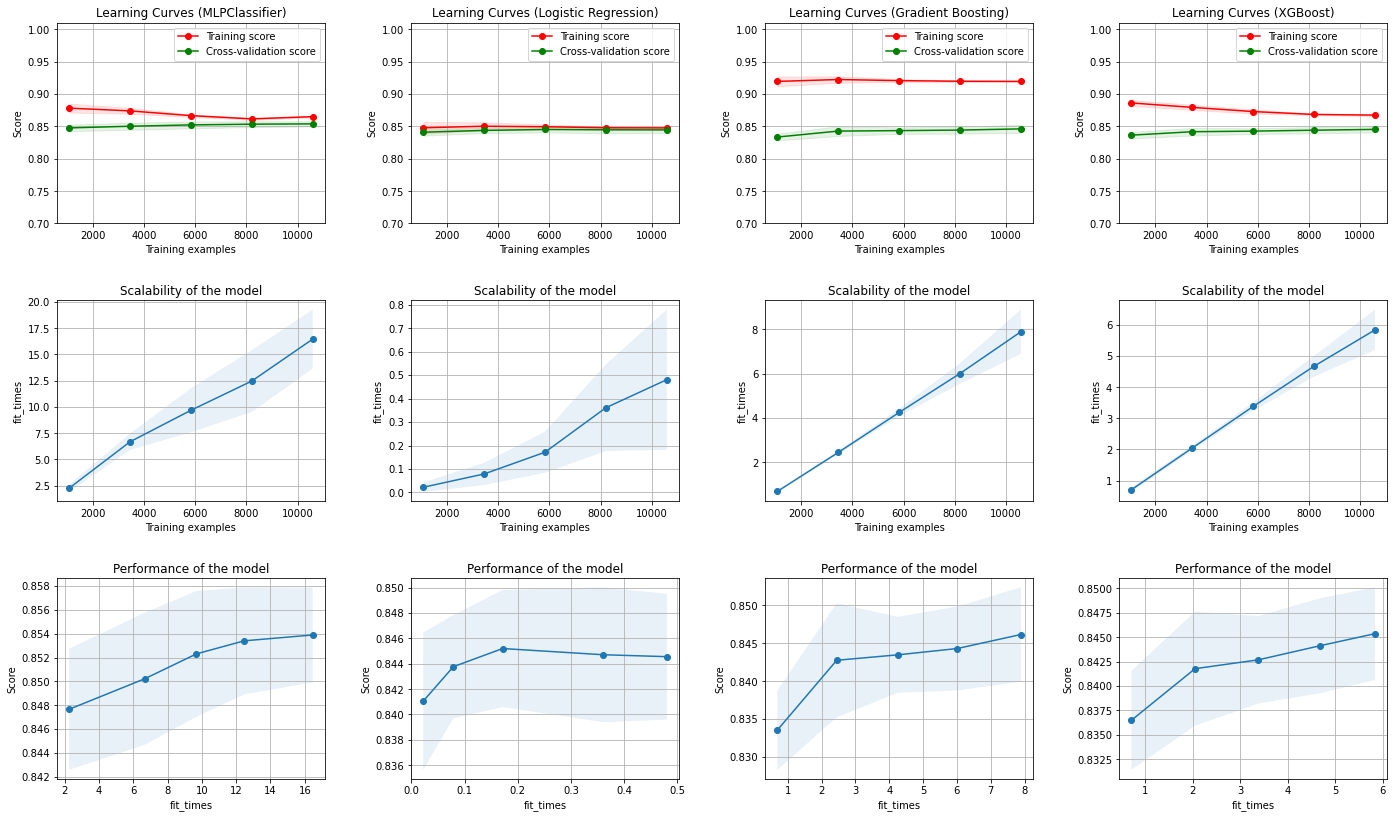

In [123]:
# Plot learning curves of the 4 best ensemble classifiers
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
nrows=3
ncols=4
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4))
# Cross validation with 10 iterations
# score curves, each time with 20% data randomly selected as a validation set.
# Here only the training set is used.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=15611)

title = r"Learning Curves (MLPClassifier)"
plot_learning_curve(clf_base_nonensemble.best_estimator_,
    title, X_train_transformed, y_train, 
    axes=axes[:, 0], ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

title = r"Learning Curves (Logistic Regression)"
plot_learning_curve(logit,
    title, X_train_transformed, y_train, 
    axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

title = r"Learning Curves (Gradient Boosting)"
plot_learning_curve(clf_base_ensemble.best_estimator_,
    title, X_train_transformed, y_train, 
    axes=axes[:, 2], ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

title = r"Learning Curves (XGBoost)"
plot_learning_curve(xgbc,
    title, X_train_transformed, y_train_transformed, 
    axes=axes[:, 3], ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

plt.tight_layout(pad=3.0)
plt.show();

The MLP models are somewhat underfitting, judging by learning curves. Training score decreases relatively rapidly while cross-validation score climbes slowly, with increasing the number of examples. both Gradient boosting XGBoosting are clearly overfitting. Logistic regression perform just well. 

## Best predictive model

In [81]:
# Best prediction score
print('Prediction and CV scores of the 5 best models:\n')
print('Model \t\t\tprediction score\tCV score')
print('----------------------------------------------------------')
# Non-ensemble model
base_non_roc_auc = calculate_roc_auc_score(clf_base_nonensemble.best_estimator_, X_valid_transformed, y_valid_transformed)
print('Neural Net (MLP)\t{}\t\t\t{}'.format(round(base_non_roc_auc,4),round(clf_base_nonensemble.best_score_,4)))
logit_roc_auc = calculate_roc_auc_score(logit, X_valid_transformed,y_valid_transformed) 
print('Logit regression\t{}\t\t\t{}'.format(round(logit_roc_auc,4,),round(clf_base_nonensemble.cv_results_['mean_test_score'][0],4)))
## Gaussian process  
clf_gp_train_roc_auc = calculate_roc_auc_score(screening_results['model']['Gaussian Process'], X_valid_transformed, y_valid_transformed)
clf_gp_roc_auc = screening_results['score']['Gaussian Process'] 
print('Guassian Process\t{}\t\t\t{}'.format(round(clf_gp_roc_auc,4),round(clf_gp_train_roc_auc,4)))
# Ensemble
base_ens_roc_auc = calculate_roc_auc_score(clf_base_ensemble.best_estimator_, X_valid_transformed, y_valid_transformed)
print('Gradient Boosting\t{}\t\t\t{}'.format(round(base_ens_roc_auc,4),round(clf_base_ensemble.best_score_,4)))
xgbc_roc_auc = calculate_roc_auc_score(xgbc, X_valid_transformed,y_valid_transformed) 
print('XGBoosting      \t{}\t\t\t{}'.format(round(xgbc_roc_auc,4),round(clf_base_ensemble.cv_results_['mean_test_score'][16],4)))


Prediction and CV scores of the 5 best models:

Model 			prediction score	CV score
----------------------------------------------------------
Neural Net (MLP)	0.8359			0.8342
Logit regression	0.82			0.8205
Guassian Process	0.8322			0.8319
Gradient Boosting	0.824			0.8316
XGBoosting      	0.8239			0.8304


In [135]:
score_best = {'Neural Net':base_non_roc_auc, 'Logistic Regression':logit_roc_auc,'Guassian Process':clf_gp_roc_auc,
              'Gradient Boosting':base_ens_roc_auc,'XGBoost':xgbc_roc_auc}
model_best = {'Neural Net':clf_base_nonensemble.best_estimator_, 
              'Logistic Regression':logit,
              'Guassian Process':screening_results['model']['Gaussian Process'],
              'Gradient Boosting':clf_base_ensemble.best_estimator_,
              'XGBoost':xgbc}
best_models = {'score':score_best, 'model':model_best}

In [136]:
joblib.dump(best_models, 'Best base models.joblib')

['Best base models.joblib']

In [80]:
# Best model:
clf_base_nonensemble.best_params_

{'classifier': MLPClassifier(activation='tanh', alpha=0.2121879236856809,
               learning_rate='invscaling', random_state=15611),
 'classifier__activation': 'tanh',
 'classifier__alpha': 0.2121879236856809,
 'classifier__learning_rate': 'invscaling',
 'classifier__solver': 'adam'}

The ***best predictive model*** is the ***Multi_Layer Perceptron classifier*** from scikit learn's neural_network model, with default ***"tanh"*** activation function and ***"adam"*** solver, ***"invscaling"*** learning rate schedule, and L2 penalty regulization parameter ***alpha = 0.2122***. <br>

Ggradient boosting and XGBoosting have almost the same prediction accuracy, which are about 1% point lower than the best models (MLP and Guassian process). Logistic regression is slight lower (0.4% point) than the best ensemble models. <br>

## Feature importance
### Feature list from pipeline

In [87]:
depend = ['dependents']
cat_vars = ['gender', 'occupation']#,'branch_code']

nw_cat = ['customer_nw_category']
bal_vars = ['current_balance', 'current_month_balance', 
            'previous_month_end_balance','previous_month_balance',
            'average_monthly_balance_prevQ', 'average_monthly_balance_prevQ2']
debit_vars = ['current_month_debit','previous_month_debit']
credit_vars = ['current_month_credit', 'previous_month_credit']

target = 'churn'

In [85]:
X_train_transformed.shape

(13240, 30)

In [88]:
vars_list = [depend,cat_vars,nw_cat,vin_age_vars,days_br_vars,bal_vars,debit_vars,credit_vars]
last_steps = ['ohe_depend','ohe_cat','','scal_base','scal_days_br','scal_bal','scal_debit','scal_credit']

In [91]:
# get the features after transformation
features_fin = []
for key, step, vars in zip(list(pipeline_data.named_transformers_.keys())[:-1], last_steps, vars_list):
#     print(key, step, vars)
    if key == 'depend':
        features_fin.extend(list(pipeline_data.named_transformers_[key][step].get_feature_names() + '_dependents'))
    elif key == 'cat_vars':
        features_fin.extend(list(pipeline_data.named_transformers_[key][step].get_feature_names()))
    elif key == 'ode_nw':
        features_fin.extend(list(nw_cat))
    else:
        features_fin.extend(vars)
len(features_fin)

30

### Permutation importance

In [92]:
from sklearn.inspection import permutation_importance
fpi_train_nonens = permutation_importance(clf_base_nonensemble.best_estimator_, X_train_transformed, y_train_transformed, scoring='roc_auc')
fpi_valid_nonens = permutation_importance(clf_base_nonensemble.best_estimator_, X_valid_transformed, y_valid_transformed, scoring='roc_auc')

fpi_train_ens = permutation_importance(clf_base_ensemble.best_estimator_, X_train_transformed, y_train_transformed, scoring='roc_auc')
fpi_valid_ens = permutation_importance(clf_base_ensemble.best_estimator_, X_valid_transformed, y_valid_transformed, scoring='roc_auc')

In [102]:
fpi_valid_nonens = fpi_test_nonens
fpi_valid_ens = fpi_test_ens

In [93]:
fpi_train_nonens['importances_mean']

array([9.73876252e-04, 1.86295136e-04, 5.50049276e-04, 1.42836518e-04,
       1.48334080e-04, 1.39476500e-05, 2.73877228e-05, 2.75077540e-03,
       1.68848063e-03, 6.20538168e-04, 3.80825892e-05, 2.66084845e-05,
       1.01744210e-03, 4.12074061e-04, 5.82712942e-05, 2.21649677e-03,
       2.32942912e-03, 2.35360696e-03, 1.28100336e-03, 1.38472069e-03,
       2.13444998e-01, 6.73851506e-02, 3.80021632e-03, 1.20141382e-02,
       1.84251259e-01, 4.23380308e-02, 1.94584730e-02, 2.74971736e-03,
       4.64007789e-03, 3.61387829e-03])

In [137]:
def plot_feature_importance(fpi,dataset=['train'], model=['regression']):
    """ plot feaute importance
        fpi: list of feautre importance lists.
        dataset: list of dataset names
        model: list of model names
    """
    ncols = len(dataset)
    plt.figure(figsize=(ncols*5,4))
    for i in range(ncols):
        plt.subplot(1,ncols,i+1)
        plt.bar(range(len(fpi[i])), fpi[i],1, i)
        plt.title(model[i] + ': Feature Importance - ' + dataset[i] + ' set')

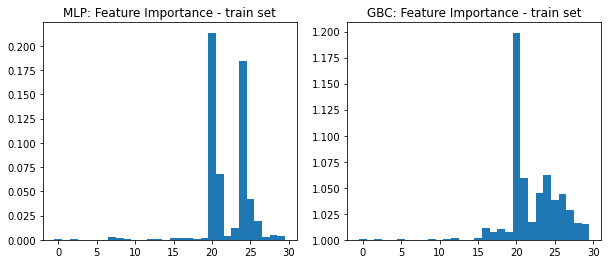

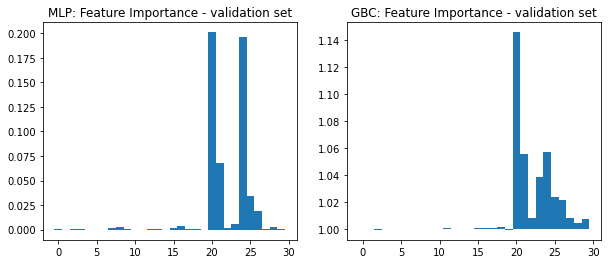

In [138]:
plot_feature_importance([fpi_train_nonens['importances_mean'], fpi_train_ens['importances_mean']], dataset=['train']*2, model=['MLP', 'GBC'])
plot_feature_importance([fpi_valid_nonens['importances_mean'], fpi_valid_ens['importances_mean']], dataset=['validation']*2, model=['MLP', 'GBC'])

In [106]:
feat_importances = pd.DataFrame.from_dict({'features':features_fin,
             'MLP_train':fpi_train_nonens['importances_mean'],
             'MLP_valid':fpi_valid_nonens['importances_mean'],
             'GBC_train':fpi_train_ens['importances_mean'],
             'GBC_valid':fpi_valid_ens['importances_mean']}).sort_values(['MLP_valid'],ascending=False)

In [107]:
print(feat_importances[feat_importances['MLP_valid']>=0.001].shape)
feat_importances[feat_importances['MLP_valid']>=0.001]

(13, 5)


,features,MLP_train,MLP_valid,GBC_train,GBC_valid
20,current_balance,0.213445,0.200993,0.198901,0.145589
24,average_monthly_balance_prevQ,0.184251,0.195772,0.062313,0.057100
21,current_month_balance,0.067385,0.067447,0.059468,0.055262
25,average_monthly_balance_prevQ2,0.042338,0.034687,0.038402,0.023968
26,current_month_debit,0.019458,0.019143,0.044245,0.021654
23,previous_month_balance,0.012014,0.005270,0.044711,0.038416
16,vintage,0.002329,0.003213,0.011014,0.000867
28,current_month_credit,0.004640,0.003114,0.016368,0.004630
8,x0_Male,0.001688,0.002626,0.000244,0.000141
22,previous_month_end_balance,0.003800,0.002056,0.017165,0.008127


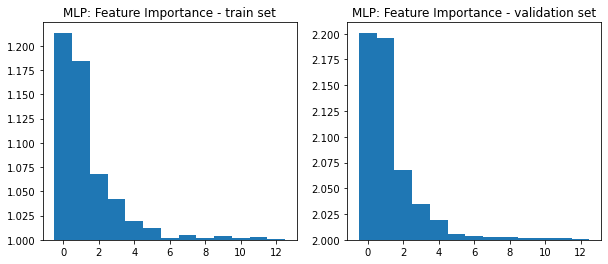

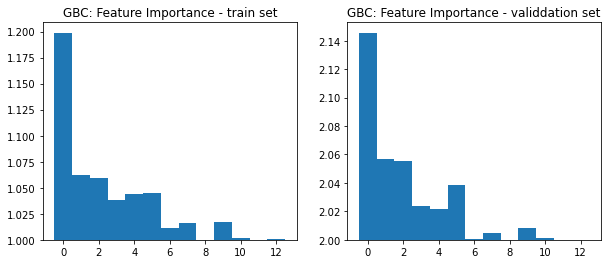

In [108]:
idx = feat_importances[feat_importances['MLP_valid']>=0.001].index
plot_feature_importance(fpi_train_nonens['importances_mean'][idx], fpi_valid_nonens['importances_mean'][idx], dataset=['train','validation'], model='MLP')
plot_feature_importance(fpi_train_ens['importances_mean'][idx], fpi_valid_ens['importances_mean'][idx], dataset=['train','validdation'], model='GBC')

The above dataframe and bar plot shows the 13 most important features in predicting the churn. We could use these features to further train the model and evaluate the effects of feature selection on performace of the candidate models. <br>

They also showes that the most importance feature are similar for both MLP and GBC models, although the acture values of th eimportance may differ. <br>

## Save the best model

In [109]:
joblib.dump(clf_base_nonensemble.best_estimator_, 'Best base churn classifier.joblib')

['Best base churn classifier.joblib']